In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/OCT_dataset/dataset_splits (AMD).zip" -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset_splits (AMD)/val/masks/Farsiu_Ophthalmology_2013_AMD_Subject_1201_slice_069_vis.png  
  inflating: /content/__MACOSX/dataset_splits (AMD)/val/masks/._Farsiu_Ophthalmology_2013_AMD_Subject_1201_slice_069_vis.png  
  inflating: /content/dataset_splits (AMD)/val/masks/Farsiu_Ophthalmology_2013_AMD_Subject_1169_slice_014_vis.png  
  inflating: /content/__MACOSX/dataset_splits (AMD)/val/masks/._Farsiu_Ophthalmology_2013_AMD_Subject_1169_slice_014_vis.png  
  inflating: /content/dataset_splits (AMD)/val/masks/Farsiu_Ophthalmology_2013_AMD_Subject_1150_slice_021.png  
  inflating: /content/__MACOSX/dataset_splits (AMD)/val/masks/._Farsiu_Ophthalmology_2013_AMD_Subject_1150_slice_021.png  
  inflating: /content/dataset_splits (AMD)/val/masks/Farsiu_Ophthalmology_2013_AMD_Subject_1248_slice_030.png  
  inflating: /content/__MACOSX/dataset_splits (AMD)/val/masks/._Farsiu_Ophthalmology_2013_AMD_Subject_1248_slice_030

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
import numpy as np
from tqdm import tqdm

# -------------------
# CONFIG
# -------------------
DATA_DIR = "/content/dataset_splits (AMD)"
NUM_CLASSES = 4        # background + 3 retinal layers
BATCH_SIZE = 8
EPOCHS = 20
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEST_MODEL_PATH = "shallow_cnn_best.pth"

print("Using device:", DEVICE)

# -------------------
# DATASET
# -------------------
class OCTDataset(Dataset):
    def __init__(self, root_dir):
        self.img_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        # All images
        self.img_files = sorted([f for f in os.listdir(self.img_dir) if f.endswith(".png")])
        # Masks excluding vis.png
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if f.endswith(".png") and "vis" not in f])
        # Only keep matching files
        self.files = [f for f in self.img_files if f in self.mask_files]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        # Load image (grayscale) and convert to 3 channels
        img = np.array(Image.open(os.path.join(self.img_dir, img_name)).convert("L"))
        img = np.stack([img, img, img], axis=0)
        img = torch.tensor(img, dtype=torch.float32) / 255.0

        # Load mask
        mask = np.array(Image.open(os.path.join(self.mask_dir, img_name)).convert("L"))
        mask = torch.tensor(mask, dtype=torch.long)

        return img, mask

# Datasets and loaders
train_ds = OCTDataset(os.path.join(DATA_DIR, "train"))
val_ds   = OCTDataset(os.path.join(DATA_DIR, "val"))
test_ds  = OCTDataset(os.path.join(DATA_DIR, "test"))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# -------------------
# MODEL
# -------------------
class ShallowCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x128 -> 64x64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64 -> 32x32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv3
            nn.ReLU(),
            nn.MaxPool2d(2)   # 32x32 -> 16x16
        )

        # Decoder (upsampling back to original size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 16 -> 32
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),   # 32 -> 64
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),   # 64 -> 128
            nn.ReLU(),

            nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2),   # 128 -> 256
            nn.ReLU(),

            nn.Conv2d(16, num_classes, kernel_size=1)  # final logits
        )

    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      # Ensure output matches target mask size
      x = nn.functional.interpolate(x, size=(256, 256), mode="bilinear", align_corners=False)
      return x


model = ShallowCNN(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# -------------------
# DICE SCORE
# -------------------
def dice_score(pred, target, num_classes=4, smooth=1e-6):
    pred = torch.argmax(pred, dim=1)  # (B,H,W)
    dice = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice.append(((2*intersection + smooth) / (union + smooth)).cpu().item())
    return dice

# -------------------
# TRAIN / EVAL FUNCTIONS
# -------------------
def train_one_epoch(loader, model, optimizer, criterion):
    model.train()
    running_loss = 0
    for imgs, masks in tqdm(loader):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(loader, model, criterion):
    model.eval()
    running_loss = 0
    dice_sum = np.zeros(NUM_CLASSES)
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            dice = dice_score(outputs, masks)
            dice_sum += np.array(dice)
    avg_dice = dice_sum / len(loader)
    return running_loss / len(loader), avg_dice

# -------------------
# TRAIN LOOP
# -------------------
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(train_loader, model, optimizer, criterion)
    val_loss, val_dice = evaluate(val_loader, model, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
    print(f"Val Dice per class: {val_dice}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("✅ Best model saved!")

# Save final model
torch.save(model.state_dict(), "shallow_cnn_final.pth")

Using device: cuda
Train: 14254, Val: 3127, Test: 3133


100%|██████████| 1782/1782 [01:44<00:00, 17.01it/s]


Epoch 1/20, Train Loss=0.7857, Val Loss=0.5444
Val Dice per class: [7.70107989e-01 6.37988342e-01 1.01657241e-10 8.53581143e-01]
✅ Best model saved!


100%|██████████| 1782/1782 [01:41<00:00, 17.54it/s]


Epoch 2/20, Train Loss=0.4751, Val Loss=0.4370
Val Dice per class: [8.37791404e-01 6.83116898e-01 1.01657241e-10 8.83244948e-01]
✅ Best model saved!


100%|██████████| 1782/1782 [01:41<00:00, 17.56it/s]


Epoch 3/20, Train Loss=0.4026, Val Loss=0.3723
Val Dice per class: [8.69625796e-01 7.09048922e-01 1.01657241e-10 9.04924452e-01]
✅ Best model saved!


100%|██████████| 1782/1782 [01:42<00:00, 17.43it/s]


Epoch 4/20, Train Loss=0.3527, Val Loss=0.3319
Val Dice per class: [8.81070525e-01 7.55397307e-01 1.01657241e-10 9.16687232e-01]
✅ Best model saved!


100%|██████████| 1782/1782 [01:41<00:00, 17.64it/s]


Epoch 5/20, Train Loss=0.3166, Val Loss=0.3066
Val Dice per class: [8.86488808e-01 7.83897678e-01 6.24291740e-05 9.24007809e-01]
✅ Best model saved!


100%|██████████| 1782/1782 [01:40<00:00, 17.66it/s]


Epoch 6/20, Train Loss=0.2947, Val Loss=0.2890
Val Dice per class: [0.89357361 0.80524172 0.0678688  0.93072136]
✅ Best model saved!


100%|██████████| 1782/1782 [01:40<00:00, 17.67it/s]


Epoch 7/20, Train Loss=0.2813, Val Loss=0.2799
Val Dice per class: [0.8969897  0.81636078 0.17668737 0.93282374]
✅ Best model saved!


100%|██████████| 1782/1782 [01:41<00:00, 17.59it/s]


Epoch 8/20, Train Loss=0.2708, Val Loss=0.2675
Val Dice per class: [0.90183336 0.822712   0.25258933 0.93585249]
✅ Best model saved!


100%|██████████| 1782/1782 [01:41<00:00, 17.62it/s]


Epoch 9/20, Train Loss=0.2630, Val Loss=0.2599
Val Dice per class: [0.90536923 0.82929024 0.30689607 0.93894108]
✅ Best model saved!


100%|██████████| 1782/1782 [01:41<00:00, 17.61it/s]


Epoch 10/20, Train Loss=0.2564, Val Loss=0.2559
Val Dice per class: [0.90582933 0.83241914 0.3611746  0.93952237]
✅ Best model saved!


100%|██████████| 1782/1782 [01:41<00:00, 17.55it/s]


Epoch 11/20, Train Loss=0.2510, Val Loss=0.2526
Val Dice per class: [0.90809182 0.84115411 0.39438583 0.94119217]
✅ Best model saved!


100%|██████████| 1782/1782 [01:42<00:00, 17.46it/s]


Epoch 12/20, Train Loss=0.2458, Val Loss=0.2496
Val Dice per class: [0.90746619 0.84232309 0.42650385 0.94177395]
✅ Best model saved!


100%|██████████| 1782/1782 [01:41<00:00, 17.57it/s]


Epoch 13/20, Train Loss=0.2410, Val Loss=0.2484
Val Dice per class: [0.90667402 0.84404775 0.4548758  0.94041742]
✅ Best model saved!


100%|██████████| 1782/1782 [01:41<00:00, 17.48it/s]


Epoch 14/20, Train Loss=0.2374, Val Loss=0.2387
Val Dice per class: [0.91076616 0.85106773 0.4684982  0.94350022]
✅ Best model saved!


100%|██████████| 1782/1782 [01:41<00:00, 17.63it/s]


Epoch 15/20, Train Loss=0.2314, Val Loss=0.2346
Val Dice per class: [0.9151834  0.84831815 0.48868869 0.94531367]
✅ Best model saved!


100%|██████████| 1782/1782 [01:41<00:00, 17.58it/s]


Epoch 16/20, Train Loss=0.2288, Val Loss=0.2292
Val Dice per class: [0.91846406 0.85576041 0.50004565 0.94792001]
✅ Best model saved!


100%|██████████| 1782/1782 [01:41<00:00, 17.59it/s]


Epoch 17/20, Train Loss=0.2247, Val Loss=0.2280
Val Dice per class: [0.91624265 0.85512342 0.51561284 0.94619871]
✅ Best model saved!


100%|██████████| 1782/1782 [01:40<00:00, 17.65it/s]


Epoch 18/20, Train Loss=0.2232, Val Loss=0.2261
Val Dice per class: [0.91765285 0.85092297 0.50783431 0.94704763]
✅ Best model saved!


100%|██████████| 1782/1782 [01:41<00:00, 17.62it/s]


Epoch 19/20, Train Loss=0.2185, Val Loss=0.2217
Val Dice per class: [0.92058027 0.86191587 0.50531176 0.94924912]
✅ Best model saved!


100%|██████████| 1782/1782 [01:40<00:00, 17.69it/s]


Epoch 20/20, Train Loss=0.2166, Val Loss=0.2213
Val Dice per class: [0.9163286  0.86241333 0.51353636 0.94933089]
✅ Best model saved!


In [4]:
!pip install PyMaxflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.2/939.2 kB 17.1 MB/s eta 0:00:00


In [5]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from tqdm import tqdm
import maxflow  # PyMaxflow

# -------------------
# CONFIG
# -------------------
TEST_DIR = "/content/dataset_splits (AMD)/test"
PRED_DIR = "/content/shallowcnn_predictions"        # CNN-only predictions
GC_DIR = "/content/shallowcnn_graphcut_predictions" # Graph-cut refined predictions

NUM_CLASSES = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "shallow_cnn_best.pth"  # <-- set to your shallow CNN checkpoint if different

os.makedirs(PRED_DIR, exist_ok=True)
os.makedirs(GC_DIR, exist_ok=True)

# -------------------
# DATASET
# -------------------
class OCTDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.img_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.img_files = sorted([f for f in os.listdir(self.img_dir) if f.endswith(".png")])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if f.endswith(".png") and "vis" not in f])
        # assumes masks use same filename as images
        self.files = [f for f in self.img_files if f in self.mask_files]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img = np.array(Image.open(os.path.join(self.img_dir, img_name)).convert("L"))
        # training used 3-channel stacked grayscale, keep same
        img = np.stack([img, img, img], axis=0).astype(np.float32)  # (3,H,W)
        img = torch.tensor(img) / 255.0
        mask = np.array(Image.open(os.path.join(self.mask_dir, img_name)).convert("L"))
        mask = torch.tensor(mask, dtype=torch.long)
        return img, mask, img_name

# -------------------
# SHALLOW CNN (same as training)
# -------------------
class ShallowCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x128 -> 64x64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64 -> 32x32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv3
            nn.ReLU(),
            nn.MaxPool2d(2)   # 32x32 -> 16x16
        )

        # Decoder (upsampling back to original size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 16 -> 32
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),   # 32 -> 64
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),   # 64 -> 128
            nn.ReLU(),

            nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2),   # 128 -> 256
            nn.ReLU(),

            nn.Conv2d(16, num_classes, kernel_size=1)  # final logits
        )

    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      # Ensure output matches target mask size
      x = nn.functional.interpolate(x, size=(256, 256), mode="bilinear", align_corners=False)
      return x

# -------------------
# GRAPH CUT (ALPHA-EXPANSION) - robust unary construction
# -------------------
def graph_cut_alpha_expansion(probs, img_np, smooth_weight=10, max_iter=5):
    """
    probs: (H,W,C) ndarray of softmax probabilities
    img_np: (H,W) grayscale image uint8
    returns: labels (H,W) uint8
    """
    H, W, C = probs.shape
    labels = np.argmax(probs, axis=2).astype(np.uint8)

    # flattened helpers
    N = H * W
    flat_probs = probs.reshape(-1, C)  # (N, C)
    idxs = np.arange(N)

    # pairwise weights precomputed
    right_w = np.exp(-np.abs(img_np[:, :-1] - img_np[:, 1:]) / 50.0) * smooth_weight
    bottom_w = np.exp(-np.abs(img_np[:-1, :] - img_np[1:, :]) / 50.0) * smooth_weight

    for it in range(max_iter):
        old_labels = labels.copy()
        flat_labels = labels.flatten()

        for alpha in range(C):
            g = maxflow.Graph[float]()
            nodes = g.add_nodes(N)

            # unary costs (vectorized then applied in loop)
            cost_current_flat = -np.log(flat_probs[idxs, flat_labels] + 1e-12)
            cost_alpha_flat   = -np.log(flat_probs[idxs, alpha] + 1e-12)
            cost_current = cost_current_flat.reshape(H, W)
            cost_alpha = cost_alpha_flat.reshape(H, W)

            # add t-links
            for i in range(H):
                base = i * W
                for j in range(W):
                    n = nodes[base + j]
                    g.add_tedge(n, float(cost_alpha[i, j]), float(cost_current[i, j]))

            # add pairwise edges (right)
            for i in range(H):
                for j in range(W - 1):
                    a = i * W + j
                    b = a + 1
                    w = float(right_w[i, j])
                    g.add_edge(nodes[a], nodes[b], w, w)

            # add pairwise edges (down)
            for i in range(H - 1):
                for j in range(W):
                    a = i * W + j
                    b = a + W
                    w = float(bottom_w[i, j])
                    g.add_edge(nodes[a], nodes[b], w, w)

            g.maxflow()

            # update labels: segment == 1 means sink -> choose alpha
            for n in range(N):
                if g.get_segment(nodes[n]) == 1:
                    labels[n // W, n % W] = alpha

        if np.array_equal(labels, old_labels):
            break

    return labels

# -------------------
# INFERENCE + SAVE
# -------------------
test_ds = OCTDataset(TEST_DIR)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)

model = ShallowCNN(num_classes=NUM_CLASSES).to(DEVICE)

# load weights (should be a ShallowCNN checkpoint)
state = torch.load(MODEL_PATH, map_location=DEVICE)
# Try strict load; if fails, load non-strict and warn
try:
    model.load_state_dict(state)
except RuntimeError:
    # best-effort partial load (will skip unmatched keys)
    print("Warning: strict load failed, loading matching keys only (strict=False).")
    model.load_state_dict(state, strict=False)

model.eval()

with torch.no_grad():
    for imgs, masks, img_names in tqdm(test_loader, desc="ShallowCNN + GraphCut"):
        imgs = imgs.to(DEVICE)                 # (1,3,H,W)
        outputs = model(imgs)                  # (1,C,H,W)
        probs = torch.softmax(outputs.squeeze(0), dim=0).permute(1, 2, 0).cpu().numpy()  # (H,W,C)

        # CNN-only prediction
        pred_cnn = np.argmax(probs, axis=-1).astype(np.uint8)
        Image.fromarray(pred_cnn).save(os.path.join(PRED_DIR, img_names[0]))

        # Graph Cut refinement
        img_np = (imgs.squeeze(0).cpu().numpy()[0] * 255).astype(np.uint8)  # use first channel (grayscale stacked)
        refined = graph_cut_alpha_expansion(probs, img_np, smooth_weight=10, max_iter=5)
        Image.fromarray(refined.astype(np.uint8)).save(os.path.join(GC_DIR, img_names[0]))

print("✅ ShallowCNN inference + Graph Cut completed!")


ShallowCNN + GraphCut: 100%|██████████| 3133/3133 [27:04<00:00,  1.93it/s]

✅ ShallowCNN inference + Graph Cut completed!


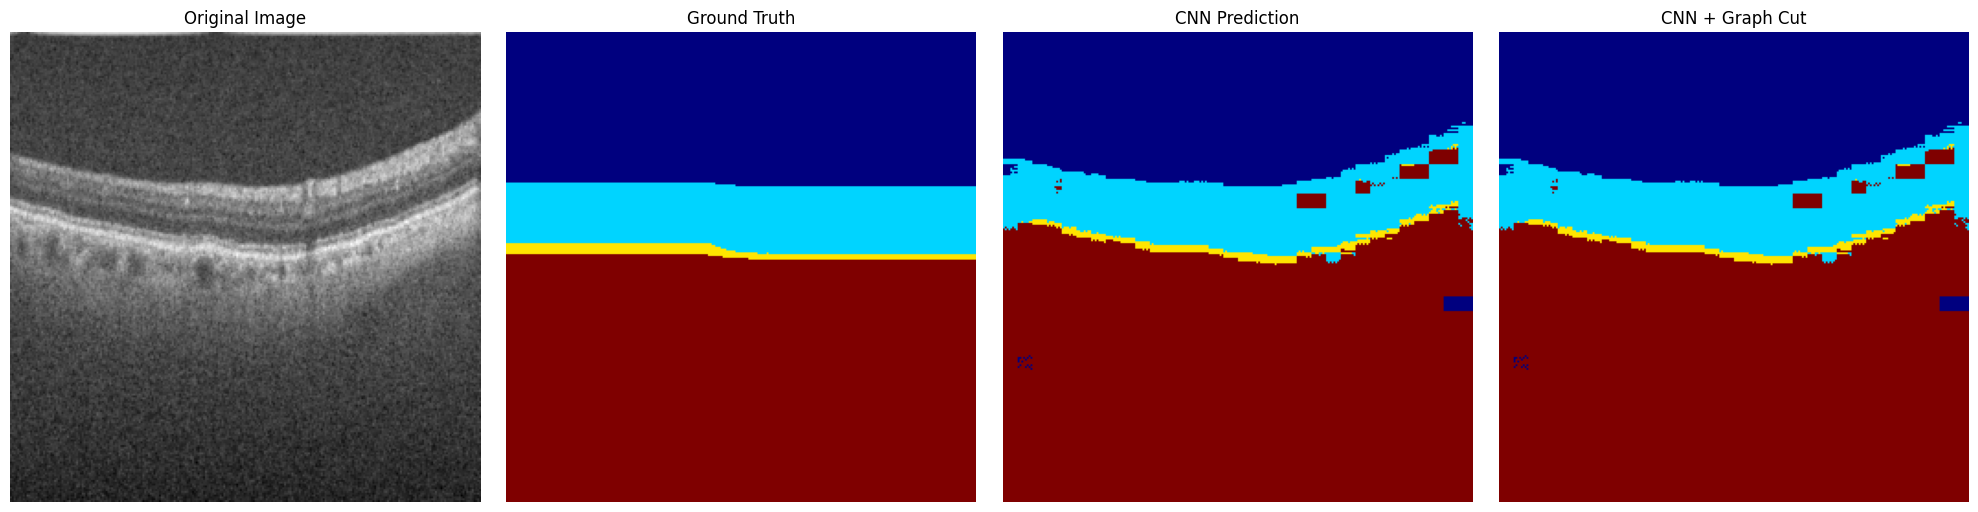

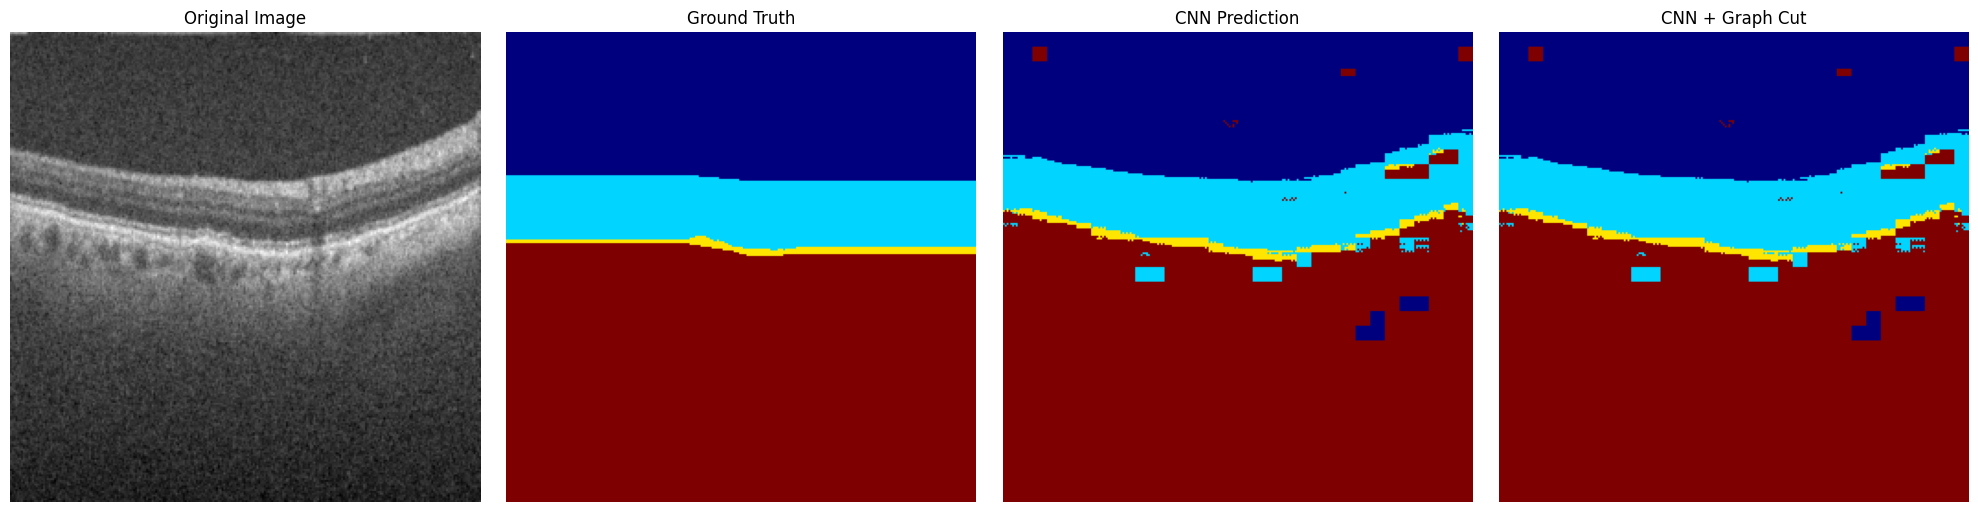

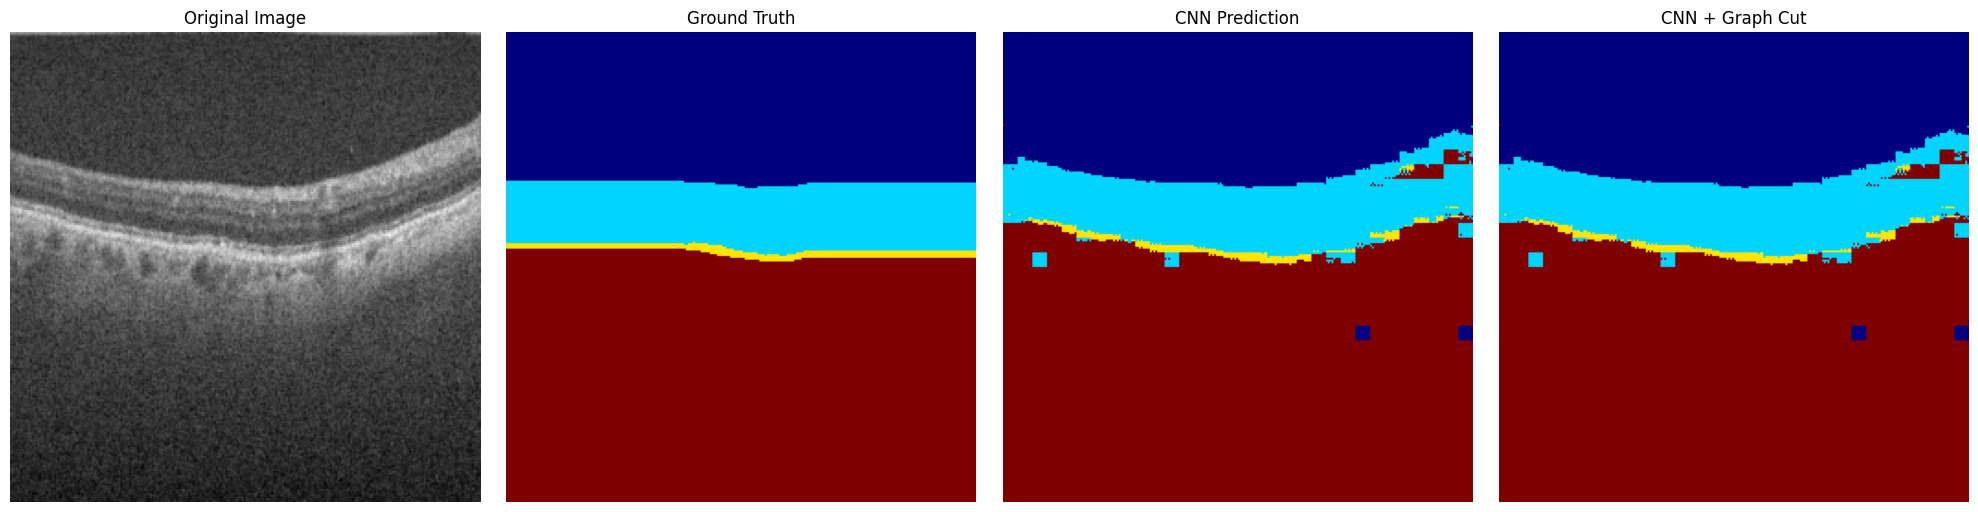

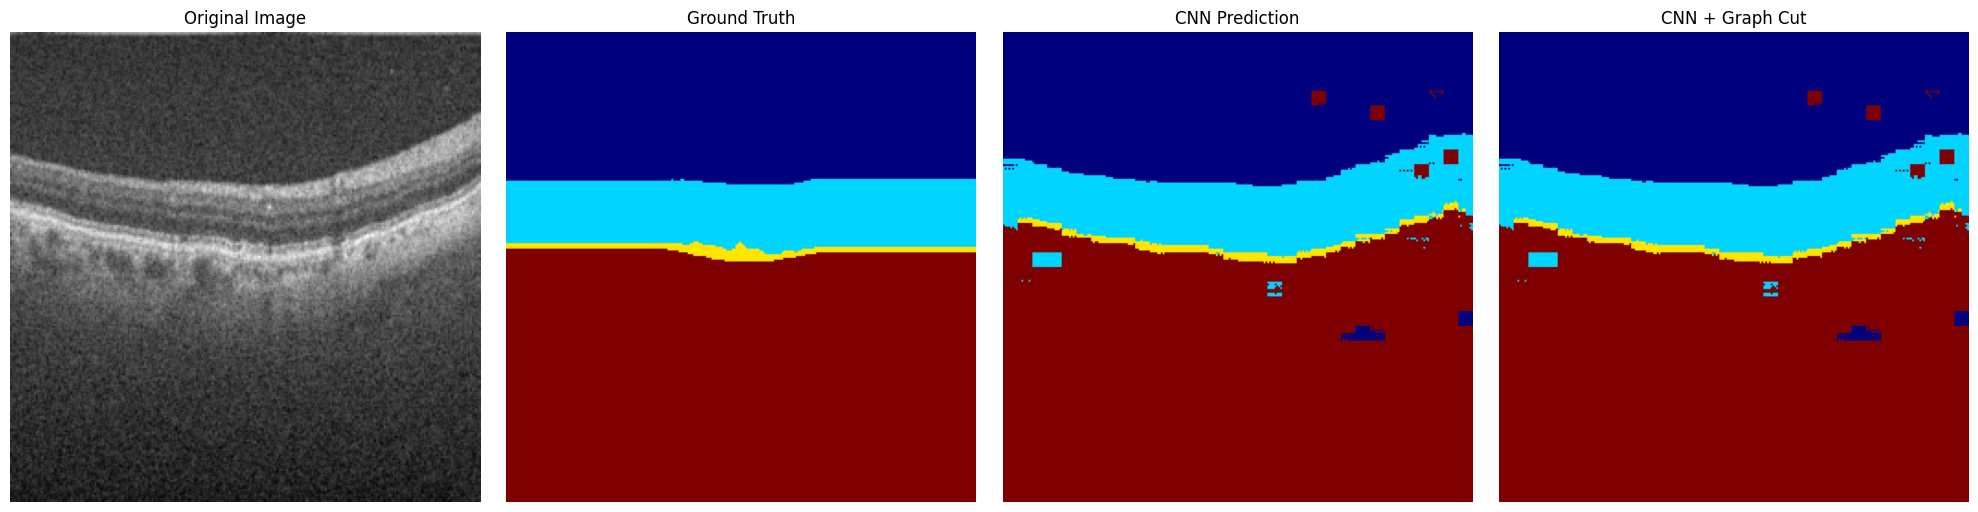

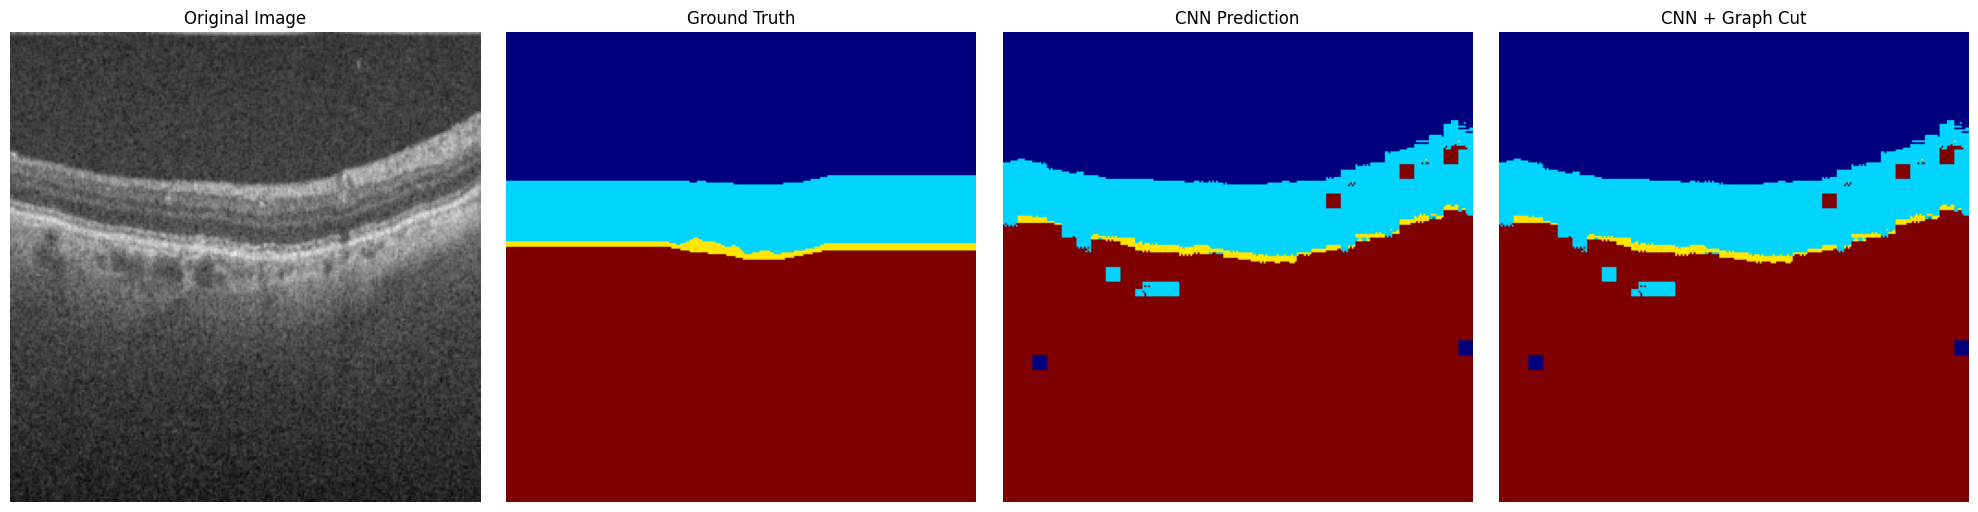

In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# -------------------
# CONFIG
# -------------------
TEST_DIR = "/content/dataset_splits (AMD)/test"
PRED_DIR = "/content/shallowcnn_predictions"
GC_DIR   = "/content/shallowcnn_graphcut_predictions"

NUM_IMAGES = 5  # Number of images to visualize

# Get list of image filenames
img_files = sorted([f for f in os.listdir(os.path.join(TEST_DIR, "images")) if f.endswith(".png")])[:NUM_IMAGES]

# -------------------
# VISUALIZATION
# -------------------
for img_name in img_files:
    img = np.array(Image.open(os.path.join(TEST_DIR, "images", img_name)).convert("L"))
    gt_mask = np.array(Image.open(os.path.join(TEST_DIR, "masks", img_name)).convert("L"))
    cnn_mask = np.array(Image.open(os.path.join(PRED_DIR, img_name))).astype(np.uint8)
    gc_mask = np.array(Image.open(os.path.join(GC_DIR, img_name))).astype(np.uint8)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(img, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(gt_mask, cmap="jet", vmin=0, vmax=3)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    axes[2].imshow(cnn_mask, cmap="jet", vmin=0, vmax=3)
    axes[2].set_title("CNN Prediction")
    axes[2].axis("off")

    axes[3].imshow(gc_mask, cmap="jet", vmin=0, vmax=3)
    axes[3].set_title("CNN + Graph Cut")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()

In [7]:
import os
import numpy as np
from PIL import Image

# -------------------
# CONFIG
# -------------------
TEST_DIR = "/content/dataset_splits (AMD)/test"
PRED_DIR = "/content/shallowcnn_predictions"
GC_DIR   = "/content/shallowcnn_graphcut_predictions"

NUM_CLASSES = 4

# -------------------
# METRIC FUNCTIONS
# -------------------
def dice_coefficient(y_true, y_pred, num_classes=4):
    dice_per_class = []
    for c in range(num_classes):
        y_true_c = (y_true == c).astype(np.uint8)
        y_pred_c = (y_pred == c).astype(np.uint8)
        intersection = np.sum(y_true_c * y_pred_c)
        union = np.sum(y_true_c) + np.sum(y_pred_c)
        dice = (2 * intersection) / (union + 1e-8)
        dice_per_class.append(dice)
    return dice_per_class, np.mean(dice_per_class)

def iou_score(y_true, y_pred, num_classes=4):
    iou_per_class = []
    for c in range(num_classes):
        y_true_c = (y_true == c).astype(np.uint8)
        y_pred_c = (y_pred == c).astype(np.uint8)
        intersection = np.sum(y_true_c * y_pred_c)
        union = np.sum((y_true_c + y_pred_c) > 0)
        iou = intersection / (union + 1e-8)
        iou_per_class.append(iou)
    return iou_per_class, np.mean(iou_per_class)

def precision_score(y_true, y_pred, num_classes=4):
    precision_per_class = []
    for c in range(num_classes):
        y_true_c = (y_true == c).astype(np.uint8)
        y_pred_c = (y_pred == c).astype(np.uint8)
        tp = np.sum(y_true_c * y_pred_c)
        fp = np.sum((y_pred_c == 1) & (y_true_c == 0))
        precision = tp / (tp + fp + 1e-8)
        precision_per_class.append(precision)
    return precision_per_class, np.mean(precision_per_class)

def recall_score(y_true, y_pred, num_classes=4):
    recall_per_class = []
    for c in range(num_classes):
        y_true_c = (y_true == c).astype(np.uint8)
        y_pred_c = (y_pred == c).astype(np.uint8)
        tp = np.sum(y_true_c * y_pred_c)
        fn = np.sum((y_true_c == 1) & (y_pred_c == 0))
        recall = tp / (tp + fn + 1e-8)
        recall_per_class.append(recall)
    return recall_per_class, np.mean(recall_per_class)

# -------------------
# LOAD FILES
# -------------------
img_files = sorted([f for f in os.listdir(os.path.join(TEST_DIR, "images")) if f.endswith(".png")])

# Store results
dice_cnn_all, dice_gc_all = [], []
iou_cnn_all, iou_gc_all = [], []
precision_cnn_all, precision_gc_all = [], []
recall_cnn_all, recall_gc_all = [], []

for img_name in img_files:
    gt_mask = np.array(Image.open(os.path.join(TEST_DIR, "masks", img_name)).convert("L"))
    cnn_mask = np.array(Image.open(os.path.join(PRED_DIR, img_name))).astype(np.uint8)
    gc_mask  = np.array(Image.open(os.path.join(GC_DIR, img_name))).astype(np.uint8)

    # Dice
    dice_cnn, _ = dice_coefficient(gt_mask, cnn_mask, NUM_CLASSES)
    dice_gc, _  = dice_coefficient(gt_mask, gc_mask, NUM_CLASSES)
    dice_cnn_all.append(dice_cnn)
    dice_gc_all.append(dice_gc)

    # IoU
    iou_cnn, _ = iou_score(gt_mask, cnn_mask, NUM_CLASSES)
    iou_gc, _  = iou_score(gt_mask, gc_mask, NUM_CLASSES)
    iou_cnn_all.append(iou_cnn)
    iou_gc_all.append(iou_gc)

    # Precision
    precision_cnn, _ = precision_score(gt_mask, cnn_mask, NUM_CLASSES)
    precision_gc, _  = precision_score(gt_mask, gc_mask, NUM_CLASSES)
    precision_cnn_all.append(precision_cnn)
    precision_gc_all.append(precision_gc)

    # Recall
    recall_cnn, _ = recall_score(gt_mask, cnn_mask, NUM_CLASSES)
    recall_gc, _  = recall_score(gt_mask, gc_mask, NUM_CLASSES)
    recall_cnn_all.append(recall_cnn)
    recall_gc_all.append(recall_gc)

# Convert to numpy arrays for averaging
dice_cnn_all = np.array(dice_cnn_all)
dice_gc_all = np.array(dice_gc_all)
iou_cnn_all = np.array(iou_cnn_all)
iou_gc_all = np.array(iou_gc_all)
precision_cnn_all = np.array(precision_cnn_all)
precision_gc_all = np.array(precision_gc_all)
recall_cnn_all = np.array(recall_cnn_all)
recall_gc_all = np.array(recall_gc_all)

# -------------------
# PRINT RESULTS
# -------------------
for c in range(NUM_CLASSES):
    print(f"Class {c}:")
    print(f"  Dice       - CNN: {dice_cnn_all[:,c].mean():.4f}, CNN+GC: {dice_gc_all[:,c].mean():.4f}")
    print(f"  IoU        - CNN: {iou_cnn_all[:,c].mean():.4f}, CNN+GC: {iou_gc_all[:,c].mean():.4f}")
    print(f"  Precision  - CNN: {precision_cnn_all[:,c].mean():.4f}, CNN+GC: {precision_gc_all[:,c].mean():.4f}")
    print(f"  Recall     - CNN: {recall_cnn_all[:,c].mean():.4f}, CNN+GC: {recall_gc_all[:,c].mean():.4f}")

print("\nMean across all classes:")
print(f"  Dice      - CNN: {dice_cnn_all.mean():.4f}, CNN+GC: {dice_gc_all.mean():.4f}")
print(f"  IoU       - CNN: {iou_cnn_all.mean():.4f}, CNN+GC: {iou_gc_all.mean():.4f}")
print(f"  Precision - CNN: {precision_cnn_all.mean():.4f}, CNN+GC: {precision_gc_all.mean():.4f}")
print(f"  Recall    - CNN: {recall_cnn_all.mean():.4f}, CNN+GC: {recall_gc_all.mean():.4f}")

Class 0:
  Dice       - CNN: 0.8977, CNN+GC: 0.8977
  IoU        - CNN: 0.8255, CNN+GC: 0.8255
  Precision  - CNN: 0.8632, CNN+GC: 0.8632
  Recall     - CNN: 0.9511, CNN+GC: 0.9511
Class 1:
  Dice       - CNN: 0.8665, CNN+GC: 0.8665
  IoU        - CNN: 0.7742, CNN+GC: 0.7742
  Precision  - CNN: 0.8692, CNN+GC: 0.8692
  Recall     - CNN: 0.8682, CNN+GC: 0.8682
Class 2:
  Dice       - CNN: 0.5170, CNN+GC: 0.5170
  IoU        - CNN: 0.3642, CNN+GC: 0.3642
  Precision  - CNN: 0.6805, CNN+GC: 0.6805
  Recall     - CNN: 0.4455, CNN+GC: 0.4455
Class 3:
  Dice       - CNN: 0.9455, CNN+GC: 0.9455
  IoU        - CNN: 0.8986, CNN+GC: 0.8986
  Precision  - CNN: 0.9562, CNN+GC: 0.9562
  Recall     - CNN: 0.9382, CNN+GC: 0.9382

Mean across all classes:
  Dice      - CNN: 0.8067, CNN+GC: 0.8067
  IoU       - CNN: 0.7156, CNN+GC: 0.7156
  Precision - CNN: 0.8423, CNN+GC: 0.8423
  Recall    - CNN: 0.8007, CNN+GC: 0.8007
